In [1]:
import preprocessing as pp
import sampling
import random
import torch
from models import simpleGCN
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2.csv"



nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))

# create the graphs for both networks
G_nerve = pp.createGraph(nodes_n, edges_n, index_addon ="n")
G_lymph = pp.createGraph(nodes_l, edges_l, index_addon ="l")

# get short description of graph
pp.graphSummary(G_nerve)
pp.graphSummary(G_lymph)

# get rid of self-loops, multi edges and isolated nodes
G_nerve_einf = pp.convertToEinfach(G_nerve)
G_lymph_einf = pp.convertToEinfach(G_lymph)

# enrich the attributes of the nodes with information from the incident edges
pp.enrichNodeAttributes(G_lymph_einf)
pp.enrichNodeAttributes(G_nerve_einf)


***************
Number of Nodes: 4317
Number of Edges: 6634
Number of Connected Components: 22
Number of Self Loops: 528
Number of Isolated Nodes: 0
Average Node Degree: 3.073430623117906
***************
***************
Number of Nodes: 3036
Number of Edges: 3864
Number of Connected Components: 89
Number of Self Loops: 25
Number of Isolated Nodes: 1
Average Node Degree: 2.5454545454545454
***************


# Graph Classification using Subsets of Lymph and Nerve Network for Training and Testing

In [3]:

# create random samples 
randomSampleLymphNx, randomSampleLymph = sampling.randomGeomSubgraphs(G_lymph_einf, label = 1,starts = 100, node_sample_size = 100,  mode = "rnn")
randomSampleNerveNx, randomSampleNerve = sampling.randomGeomSubgraphs(G_nerve_einf, label = 0,starts = 100, node_sample_size = 100,  mode = "rnn")

# combine the graphs to a random set
allGraphs = randomSampleLymph + randomSampleNerve
random.shuffle(allGraphs)

# split into training and test set
breaker = int(len(allGraphs)*0.8)
train_dataset = allGraphs[:breaker]
test_dataset = allGraphs[breaker:]

Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 525.64it/s]
Creating subgraphs using random node neighbor selection.: 100%|██████████| 100/100 [00:00<00:00, 215.18it/s]


In [4]:
# selection of the features to use
feat_slice = [1,3,7,8]

# create the model
model = simpleGCN.GCN_GC(hidden_channels=32, in_features = len(feat_slice), classes = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# create brach data loaders for training and test set
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



def train_GC():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_GC(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x[:,feat_slice], data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.



for epoch in range(1, 11):
    train_GC()
    train_acc = test_GC(train_loader)
    test_acc = test_GC(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



# good features: 1,3 - both features that have to do with length                performance is best if just these 2 features are used
# good features: 7,8 - both features that have to do with distance
# medium features: 6 - num Voxels
# medium features: 4 - curveness
# trash feature: 0,2 - both features that have to do with minRadiusAvg
# trash feature: 5 - avgRadiusStd



# 16 hidden layers seems favorable compared to 64 or 8

# slice = [1,3,7,8] leads to very good results
# slice = [1,3] results are equal to 1,3,7,8 ... maybe better

Epoch: 001, Train Acc: 0.5417, Test Acc: 0.5556
Epoch: 002, Train Acc: 0.5208, Test Acc: 0.5000
Epoch: 003, Train Acc: 0.8194, Test Acc: 0.8333
Epoch: 004, Train Acc: 0.8056, Test Acc: 0.8333
Epoch: 005, Train Acc: 0.9167, Test Acc: 0.9167
Epoch: 006, Train Acc: 0.8611, Test Acc: 0.9167
Epoch: 007, Train Acc: 0.9167, Test Acc: 0.9444
Epoch: 008, Train Acc: 0.9028, Test Acc: 0.9444
Epoch: 009, Train Acc: 0.7986, Test Acc: 0.8333
Epoch: 010, Train Acc: 0.9167, Test Acc: 0.9444


# Node Classification using a contracted graph by spatial proximity to differentiate 3 node types (nerve, lymph, connected)

In [5]:
#rename the nodes to have unqiue identifiers for different types
# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


In [6]:
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse import dok_array
from scipy.sparse.csgraph import connected_components

# create an adjacency matrix for nodes from two node sets that are closer than a given distance
adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)

# find the connected components in the adjacency matrix (nodes that will be merged)
num, labels = connected_components(csgraph=adjMcsr, directed = False)

#create a dict where each new node contains all the nodes that will be merged into it
con_comp = pp.connected_components_dict(labels)

#take only the connected components that contain > 1 element, otherwise no merge is necessary 
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))



reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



In [7]:
merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )

# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)


# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)


# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]


# create a new graph based on the old information
G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf = pp.convertToEinfach(G_contract, self_loops = True)
pp.enrichNodeAttributes(G_contract_einf)

In [8]:
# create the ground truth for the node class
all_nodes = list(G_contract_einf.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


# create the training and testing masks
train_mask = np.random.choice(np.arange(0, len(class_assign)), size=int(len(class_assign)*0.8), replace = False)
test_mask = np.arange(0, len(class_assign))[-train_mask]

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)

np.random.seed(1234567)
unique, counts = np.unique(class_assign[train_mask], return_counts=True)
print("Train-Mask Class Distribution: ")
print(unique)
print(counts)

print("Test-Mask Class Distribution: ")
unique, counts = np.unique(class_assign[test_mask], return_counts=True)
print(unique)
print(counts)


# convert the graph to a networkx graph

from torch_geometric.utils.convert import from_networkx
networkXG = from_networkx(G_contract_einf)
networkXG.y = torch.tensor(class_assign)


Train-Mask Class Distribution: 
[0 1 2]
[3227 2247  154]
Test-Mask Class Distribution: 
[0 1 2]
[3247 2235  146]


In [9]:
num_feat = networkXG.x.shape[1]
print(num_feat)
num_class = len(np.unique(networkXG.y))

feat_slice = np.arange(num_feat)
num_feat = len(feat_slice)


#model = simpleGCN.GCN_NC(hidden_channels=16, in_features =len(feat_slice),classes = num_class)
#model = simpleGCN.SAGE_NC(hidden_channels=32, in_features =len(feat_slice),classes = num_class)
model = simpleGCN.WC_NC(hidden_channels=32, in_features =len(feat_slice),classes = num_class)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-5)
criterion = torch.nn.CrossEntropyLoss()

def train_NC():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(networkXG.x[:,feat_slice], networkXG.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], networkXG.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test_NC():
      model.eval()
      out = model(networkXG.x[:,feat_slice], networkXG.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == networkXG.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / len(test_mask)  # Derive ratio of correct predictions.
      return test_acc



loss_l = []
acc_l = []
for epoch in range(1, 201):
      loss = train_NC()
      loss_l.append(loss)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      test_acc = test_NC()
      acc_l.append(test_acc)
      #print(f'Test Accuracy: {test_acc:.4f}')


test_acc = test_NC()
print(f'Test Accuracy: {test_acc:.4f}')

#100 iter:
#13: 58.75%       trash
#12: 58.75%       trash
#11: 62.03%
#10: 69.11 %
#9:  58.75 %      trash
#8:  78.69 %
#7:  78.40 %
#6:  81.08 %
#5:  58.75 %      trash
#4:  68.69 %
#3:  79.97 %
#2:  58.75 %      trash
#1:  79.97 %
#0:  58.75 %      trash

#all:        82.56 %
#no trash:   81.11 %
# >75:       81.96 %
#[1,6,8,10]: 80.77 %

#500 iter:
#all:        82.56 %


14
Epoch: 001, Loss: 12.8541
Epoch: 002, Loss: 7.8733
Epoch: 003, Loss: 8.0498
Epoch: 004, Loss: 7.8492
Epoch: 005, Loss: 7.8907
Epoch: 006, Loss: 7.2044
Epoch: 007, Loss: 6.2318
Epoch: 008, Loss: 5.4303
Epoch: 009, Loss: 4.5054
Epoch: 010, Loss: 3.9109
Epoch: 011, Loss: 3.2736
Epoch: 012, Loss: 2.7874
Epoch: 013, Loss: 2.9580
Epoch: 014, Loss: 2.9813
Epoch: 015, Loss: 2.3679
Epoch: 016, Loss: 1.9932
Epoch: 017, Loss: 1.7823
Epoch: 018, Loss: 1.6255
Epoch: 019, Loss: 1.5505
Epoch: 020, Loss: 1.5229
Epoch: 021, Loss: 1.5092
Epoch: 022, Loss: 1.3995
Epoch: 023, Loss: 1.4818
Epoch: 024, Loss: 1.4353
Epoch: 025, Loss: 1.3144
Epoch: 026, Loss: 1.2439
Epoch: 027, Loss: 1.1781
Epoch: 028, Loss: 1.1497
Epoch: 029, Loss: 1.0453
Epoch: 030, Loss: 0.9970
Epoch: 031, Loss: 0.9100
Epoch: 032, Loss: 0.8379
Epoch: 033, Loss: 0.8050
Epoch: 034, Loss: 0.7828
Epoch: 035, Loss: 0.7934
Epoch: 036, Loss: 0.7787
Epoch: 037, Loss: 0.7483
Epoch: 038, Loss: 0.7197
Epoch: 039, Loss: 0.7085
Epoch: 040, Loss: 0.6

Text(0, 0.5, 'Accuracy / %')

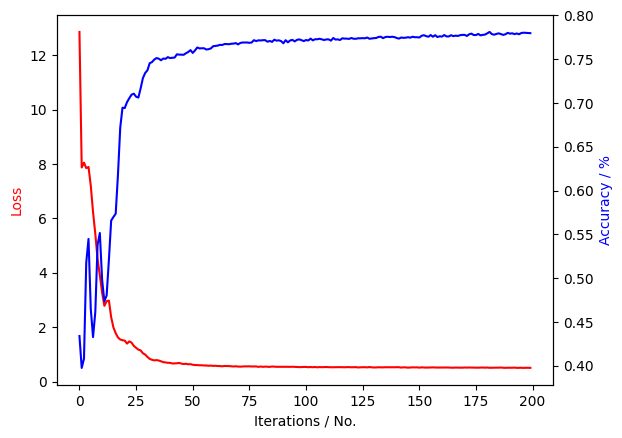

In [10]:
# all SAGE
loss_l_np = [elem.detach().numpy() for elem in loss_l]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(loss_l_np, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

Text(0, 0.5, 'Accuracy / %')

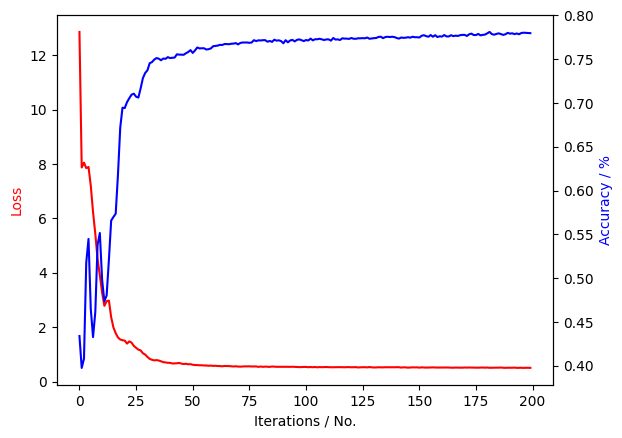

In [11]:
# all SAGE
loss_l_np = [elem.detach().numpy() for elem in loss_l]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(loss_l_np, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

Text(0, 0.5, 'Accuracy / %')

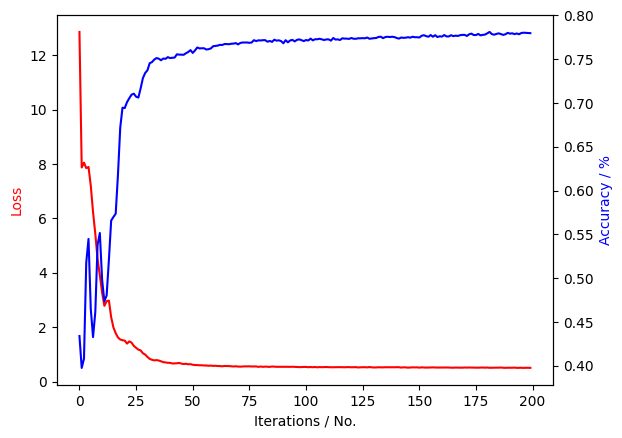

In [12]:
# all SAGE
loss_l_np = [elem.detach().numpy() for elem in loss_l]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(loss_l_np, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

Text(0, 0.5, 'Accuracy / %')

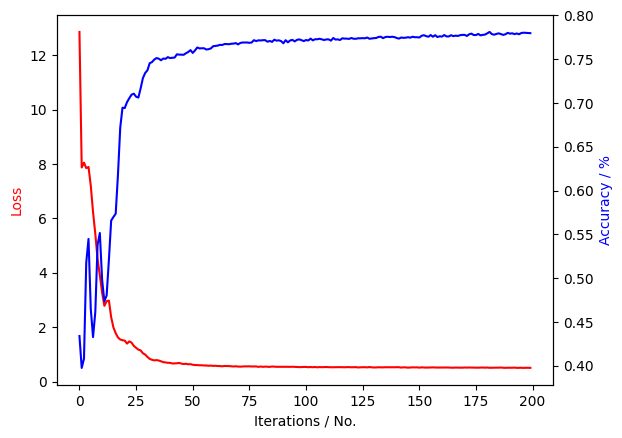

In [13]:
# all SAGE
loss_l_np = [elem.detach().numpy() for elem in loss_l]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(loss_l_np, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')

Text(0, 0.5, 'Accuracy / %')

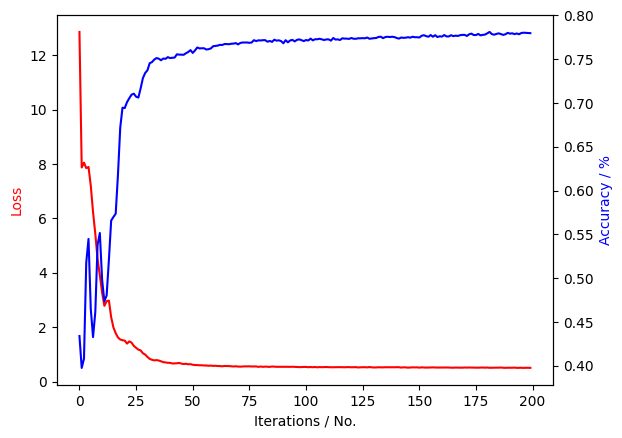

In [14]:
# all SAGE
loss_l_np = [elem.detach().numpy() for elem in loss_l]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(loss_l_np, color = "red")
ax2.plot(acc_l, color = "blue")

ax1.set_xlabel('Iterations / No.')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy / %', color='b')